In [1]:
import numpy as np
from astropy import wcs
from astropy.io import fits
from matplotlib import pyplot as plt

from astropy.table import Table
from astropy import units as u
import time

import os
import sys

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn,unique,vstack
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib import colors
from matplotlib.colors import LogNorm
from linetools.spectra.xspectrum1d import XSpectrum1D
import model_NaI
#import model_fitter
import continuum_normalize_NaI
#import NaImcmc_read_fits
#import NaImcmc_fitwrapper
#import ew_NaI_allspax
import pdb
import corner 
import glob
import os

import emcee
import numpy.ma as ma
from kcwi_jnb import cube
from kcwi_jnb import transform
from HIIdentify import HIIdentify
from HIIdentify import HIIdentify_plots

plt.rcParams['figure.figsize'] = (8,8)
plt.rc('axes', labelsize = 25)
plt.rc('axes', titlesize = 18)
#plt.rc('axes', titleweight = 'bold')
plt.rc('axes', lw = 2)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

# plt.rcParams.update({'font.size': 8})
# plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# MUSE cube directory for 2.0 binning
main_dir = '/Users/erickaguirre/mangadap/examples/'
main_dir2 = '/Users/erickaguirre/Desktop/SDSU_Research/Getting_used_to_MaNGA_DAP/'
main_dir3 = '/Users/erickaguirre/Desktop/DAP_outputs/'

# NGC 4030
NGC4030_output_dir = 'output0.6_NGC4030_NOISM_err_corr/'
NGC4030_cube_dir = 'SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/'
# log cube
NGC4030_cube0_6_file = main_dir3+ NGC4030_output_dir+ NGC4030_cube_dir+\
                       'manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits'
NGC4030_cube0_6 = fits.open(NGC4030_cube0_6_file)

# log maps
NGC4030_map_file = main_dir3+ NGC4030_output_dir+ NGC4030_cube_dir+\
                   'manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits'
NGC4030_map = fits.open(NGC4030_map_file)

# For continuum-normalization around NaI
# wavelength continuum fitting range outside of NaI region
blim = [5850.0,5870.0]
rlim = [5910.0,5930.0]
# wavelength fitting range inside of NaI region
fitlim = [5880.0,5910.0]
# speed of light in km/s
c = 2.998e5
# Na I doublet vacuum absorption wavelengths 
D2 = 5891.582 # in angstroms
D1 = 5897.558 # in angstroms

# redshift 
z = 0.00489
# obtain flux array from MUSE cube
flux = NGC4030_cube0_6['FLUX'].data
model = NGC4030_cube0_6['MODEL'].data
ivar = NGC4030_cube0_6['IVAR'].data
error = np.sqrt(1/ivar)
wave = NGC4030_cube0_6['WAVE'].data

# obtain stellar velocity, stellar dispersion and bin id data from the galaxy
stellar_vel =  NGC4030_map['STELLAR_VEL'].data
stellar_sigma = NGC4030_map['STELLAR_SIGMA'].data
binid_map = NGC4030_map['BINID'].data[0]

# Need LSF in km/s
# This gives LSF in Ang
# CAUTION: this does not convert air wavelengths
# to vacuum, or account for velocity offset of each bin
redshift = 0.00489 
LSFdir = '/Users/erickaguirre/Desktop/SDSU_Research/Getting_used_to_MaNGA_DAP/'
LSFfil = LSFdir + 'LSF-Config_MUSE_WFM'
configLSF = np.genfromtxt(LSFfil, comments='#')
configLSF_wv_air = configLSF[:,0]
configLSF_res = configLSF[:,1]

# convert to vacuum since LSF is in air
xspec = XSpectrum1D.from_tuple((configLSF_wv_air, 0.0*configLSF_wv_air))
xspec.meta['airvac'] = 'air'
xspec.airtovac()
configLSF_wv_vac = xspec.wavelength.value

configLSF_restwv = configLSF_wv_vac / (1.0+redshift)
whLSF = np.where((configLSF_restwv > fitlim[0]) & (configLSF_restwv < fitlim[1]))

median_LSFAng = np.median(configLSF_res[whLSF[0]])
median_LSFvel = c * median_LSFAng / np.median(configLSF_wv_vac[whLSF[0]])
LSFvel = median_LSFvel

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_29705/3457387990.py:37: RuntimeWarning: divide by zero encountered in divide
  error = np.sqrt(1/ivar)
/Users/erickaguirre/packages/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


In [3]:
# emission line header dictionary
emline = {}
for k, v in NGC4030_map['EMLINE_GFLUX'].header.items():
    if k[0] == 'C':
        try:
            i = int(k[1:])-1
        except ValueError:
            continue
        emline[v] = i
        
# H-alpha emission line flux from MUSE cube (1E-17 erg/s/cm^2/spaxel)
# 23rd index = 24 channel
halpha_map = NGC4030_map['EMLINE_GFLUX'].data[emline['Ha-6564'],:,:]
halpha_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Ha-6564'],:,:])
# H-beta emission line flux from MUSE cube
hbeta_map = NGC4030_map['EMLINE_GFLUX'].data[emline['Hb-4862'],:,:]
hbeta_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Hb-4862'],:,:])

# Emission line EW and error
# H-alpha 
halpha_EW_map = NGC4030_map['EMLINE_GEW'].data[emline['Ha-6564'],:,:]
halpha_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Ha-6564'],:,:])
# H-beta 
hbeta_EW_map = NGC4030_map['EMLINE_GEW'].data[emline['Hb-4862'],:,:]
hbeta_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Hb-4862'],:,:])
    
# #     if method == 'ccm':
# #     halpha and hbeta emissionlines sdss website 
# #     https://classic.sdss.org/dr7/products/spectra/vacwavelength.html
# # k_lambda_halpha = extinction.ccm89(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# # k_lambda_hbeta = extinction.ccm89(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# #     elif method == 'odonnell':
# # k_lambda_halpha = extinction.calzetti00(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# # k_lambda_hbeta = extinction.calzetti00(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# method = 'calzetti'
# if method == 'calzetti':
#     # extinction in magnitudes using Calzettie et al. 2000 extinction curve
#     k_lambda_halpha = extinction.calzetti00(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
#     k_lambda_hbeta = extinction.calzetti00(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# #     elif method == 'fitzpatrick':
# #         k_lambda_halpha = extinction.fitzpatrick99(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# #         k_lambda_hbeta = extinction.fitzpatrick99(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# #     elif method == 'fitzpatrick_massa':
# #         # assuming r_v = 3.1
# #         k_lambda_halpha = extinction.fm07(np.array([6564.614]),a_v = 4.05, unit='aa')
# #         k_lambda_hbeta = extinction.fm07(np.array([4862.721]),a_v = 4.05, unit='aa')

#     #dust attenuation map
# # if method2 == 'method1':
# ebv_map = 0.935 * np.log( (halpha_map/hbeta_map) /2.86 )
# # elif method2 == 'method2':
# # ebv_map = (1.086/(k_lambda_hbeta - k_lambda_halpha) ) * np.log( (halpha_map/hbeta_map) /2.86 )
# # ebv_map = (2.5 /(k_lambda_hbeta - k_lambda_halpha) ) * np.log10( (halpha_map/hbeta_map) /2.86 )
# # any E(B-V) value less than 0 is unrealistic, and must be changed to 0
# ebv_map[ebv_map < 0] = 0.
#     # corrected h-alpha map 
# # halpha_map_corrected = halpha_map * (10**(0.4*k_lambda_halpha*ebv_map))
# halpha_map_corrected = halpha_map * (10**(0.4*k_lambda_halpha*ebv_map))
# # replace NaN values w/ finite values
# ebv_map[np.logical_not(np.isfinite(ebv_map))] = -999
# # use good values in original h-alpha map to replace NaN values
# # in corrected h-alpha map due to nan values from ebv map
# nan_indx = np.where(np.isfinite(halpha_map_corrected) == False)
# halpha_map_corrected[nan_indx] = halpha_map[nan_indx]

# # recessional velocity of NGC 4030 (SIMBAD value) (km/s)
# v_recess = 1467.2 * (u.kilometer / u.second)
# # Hubble constant (km/s/Mpc)
# H_0 = 70 * (u.kilometer / (u.second * 1e6 * u.parsec) )
# # NGC4030 distance
# #r = (v_recess / H_0).to(u.centimeter)
# r = (29.99 * 1e6 * u.parsec).to(u.centimeter)
# # h-alpha luminosity map (ergs/s)
# L_halpha = 4*np.pi * r**2 * halpha_map_corrected * ( (1e-17 * u.erg) / (u.second * u.centimeter**2) )
# # SFR map from h-alpha luminosity in units of M_sun / year
# #SFR_map = 7.94*10**(-42) * L_halpha * (u.second / u.erg) * (u.Msun / u.year)
# SFR_map = 10**(-41.27) * L_halpha * (u.second / u.erg) * (u.Msun / u.year)
#     #return np.sum( SFR_map.flatten() )

# logSFR_map = np.log10(L_halpha.value) - 41.27
# logSFR_map[np.logical_not(np.isfinite(logSFR_map))] = -999
# halpha_map_corrected[np.logical_not(np.isfinite(halpha_map_corrected))] = -999

# # SNR per spaxel and bin ID
# snr_spxl_map = NGC4030_map['SPX_SNR'].data
# snr_bin_map = NGC4030_map['BIN_SNR'].data
# obtain image data averaged around Na I region from MUSE cube
dc = cube.DataCube(inp=NGC4030_cube0_6_file)
n_band = transform.narrowband(dc, 5880, 5910, mode='median')
img_data = n_band.data

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_29705/2667324659.py:14: RuntimeWarning: divide by zero encountered in divide
  halpha_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Ha-6564'],:,:])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_29705/2667324659.py:17: RuntimeWarning: divide by zero encountered in divide
  hbeta_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Hb-4862'],:,:])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_29705/2667324659.py:22: RuntimeWarning: divide by zero encountered in divide
  halpha_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Ha-6564'],:,:])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_29705/2667324659.py:25: RuntimeWarning: divide by zero encountered in divide
  hbeta_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Hb-4862'],:,:])


In [4]:
NGC4030_map['EMLINE_GFLUX'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  326                                                  
NAXIS2  =                  326                                                  
NAXIS3  =                   35                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      168.69830612546 / Pixel coordinate of reference point            
CRPIX2  =      162.60512922633 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
PC1_1   = -5.5555555555556E-

In [4]:
# grabbed from CD1_1 and CD2_2 info from MUSE exmaple page 
#(chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://mpdaf.readthedocs.io/en/2.5/_downloads/SourceICD.pdf)
NGC4030_map['EMLINE_GFLUX'].header['CD1_1'] = -5.549201E-05
NGC4030_map['EMLINE_GFLUX'].header['CD1_2'] =  -1.89661E-07

In [31]:
HaEW_sn = halpha_EW_map/halpha_EW_err_map
bkg_flux = HIIdentify.determine_bkg_flux(linemap = halpha_map, HaEW = halpha_EW_map,
                                          HaEW_sn =HaEW_sn , HaEWsnlim=20,
                                          distmap=None, hasn = halpha_map/halpha_err_map,
                                          hasn_lim=20, percentile = 75)

In [44]:
halpha_map_filt = halpha_map.copy()
halpha_map_filt[HaEW_sn<20] = np.nan

HIIdentify.identify_HII_regions(halpha_map_filt,  NGC4030_map['EMLINE_GFLUX'].header, 
                                flux_llim=8, flux_ulim=33, z=0.004906,\
                                obj_name='NGC4030', bkg_flux=bkg_flux, max_radius_kpc=.15,\
                                min_pixels=10, verbose=False, tdir='./', min_separation=0.05)

Removed 9 pixels with flux values above the given limit of 3.30e+01
2957 pixels have flux values above the given flux_llim of 8.00e+00
Maximum radius for the HII regions set to 7.34 pixels, 1.467 arcsec, 0.150 kpc
 Loop number 2958, 100.0% of bright pixels considered, 197 HII regions identified
All bright pixels above flux_llim have been considered. Ending search for HII regions.

Identified 197 HII regions. 14.8% of pixels assigned to a HII region 


Maps saved at:   ./NGC4030_HII_segmentation_map.fits    ./NGC4030_HII_trackermaps.fits

 Peaks tracker map: 
 -5: Pixel not considered     
 1: Surrounded by >4 non-finite values - just noise.     
 2: Adjacent to an already-identified peak, or pixel with higher flux     
 3: Median of surrounding pixels < 0.1 * peak_flux     
 4: Within 0.05kpc of another peak     
 5: Pixel successfully identified as the peak of a HII region.     
 Pixel tracker map: 
 -5: Pixel not considered     
 1: Pixel rejected - below flux threshold     
 2: Pixe


Saved  ./NGC4030ha_regionoutlines.png 



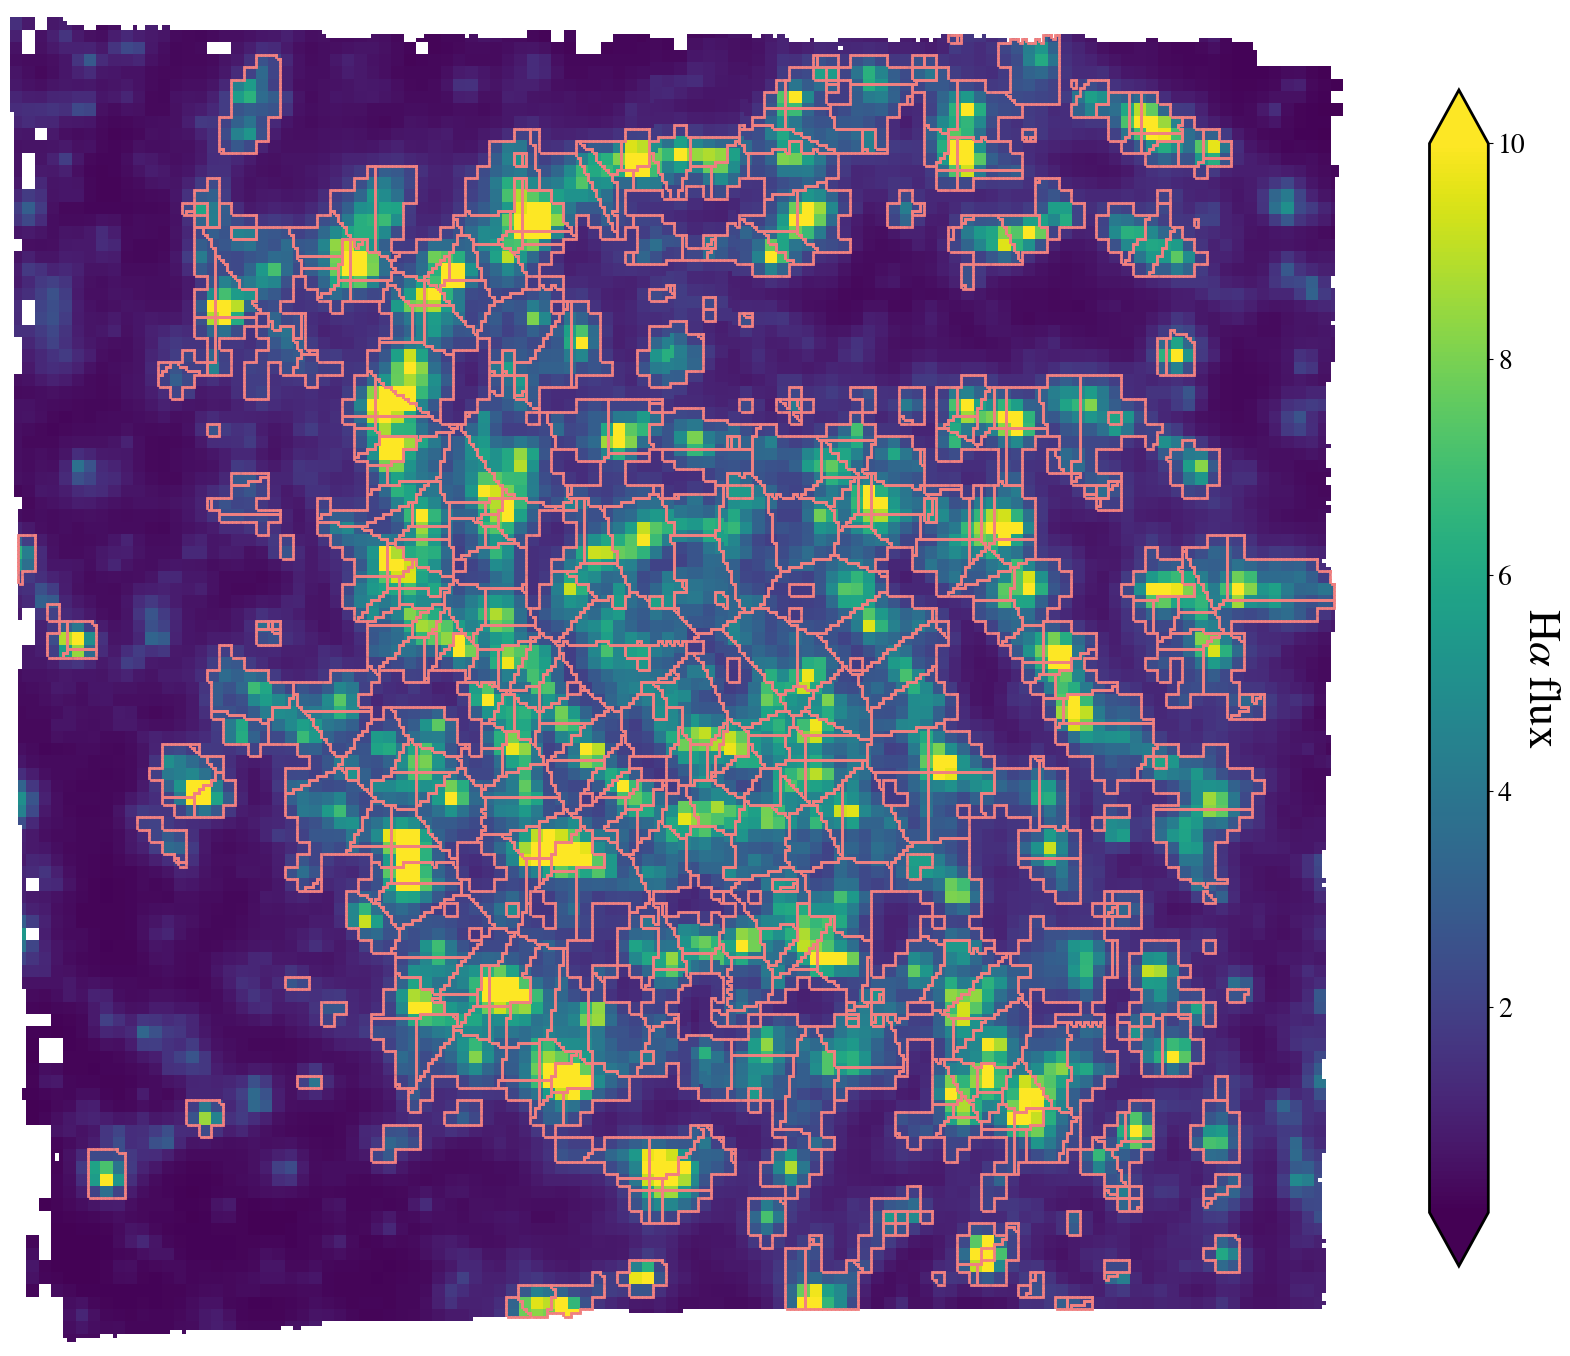

In [7]:
# flux min = 6
halpha_map_mask = ma.masked_where(HaEW_sn<14, halpha_map)
HIIdentify_plots.map_region_outline(galaxy_map=halpha_map_mask, \
            seg_map_fname='NGC4030_HII_segmentation_map.fits', vmin=0.1, vmax=10,\
            log_scaling=False, origin='lower', cbar_label=r'H$\alpha$ flux', \
            linewidth=2, tdir='./', galaxy_name='NGC4030', \
            parameter_name='ha')


Saved  ./NGC4030ha_regionoutlines.png 



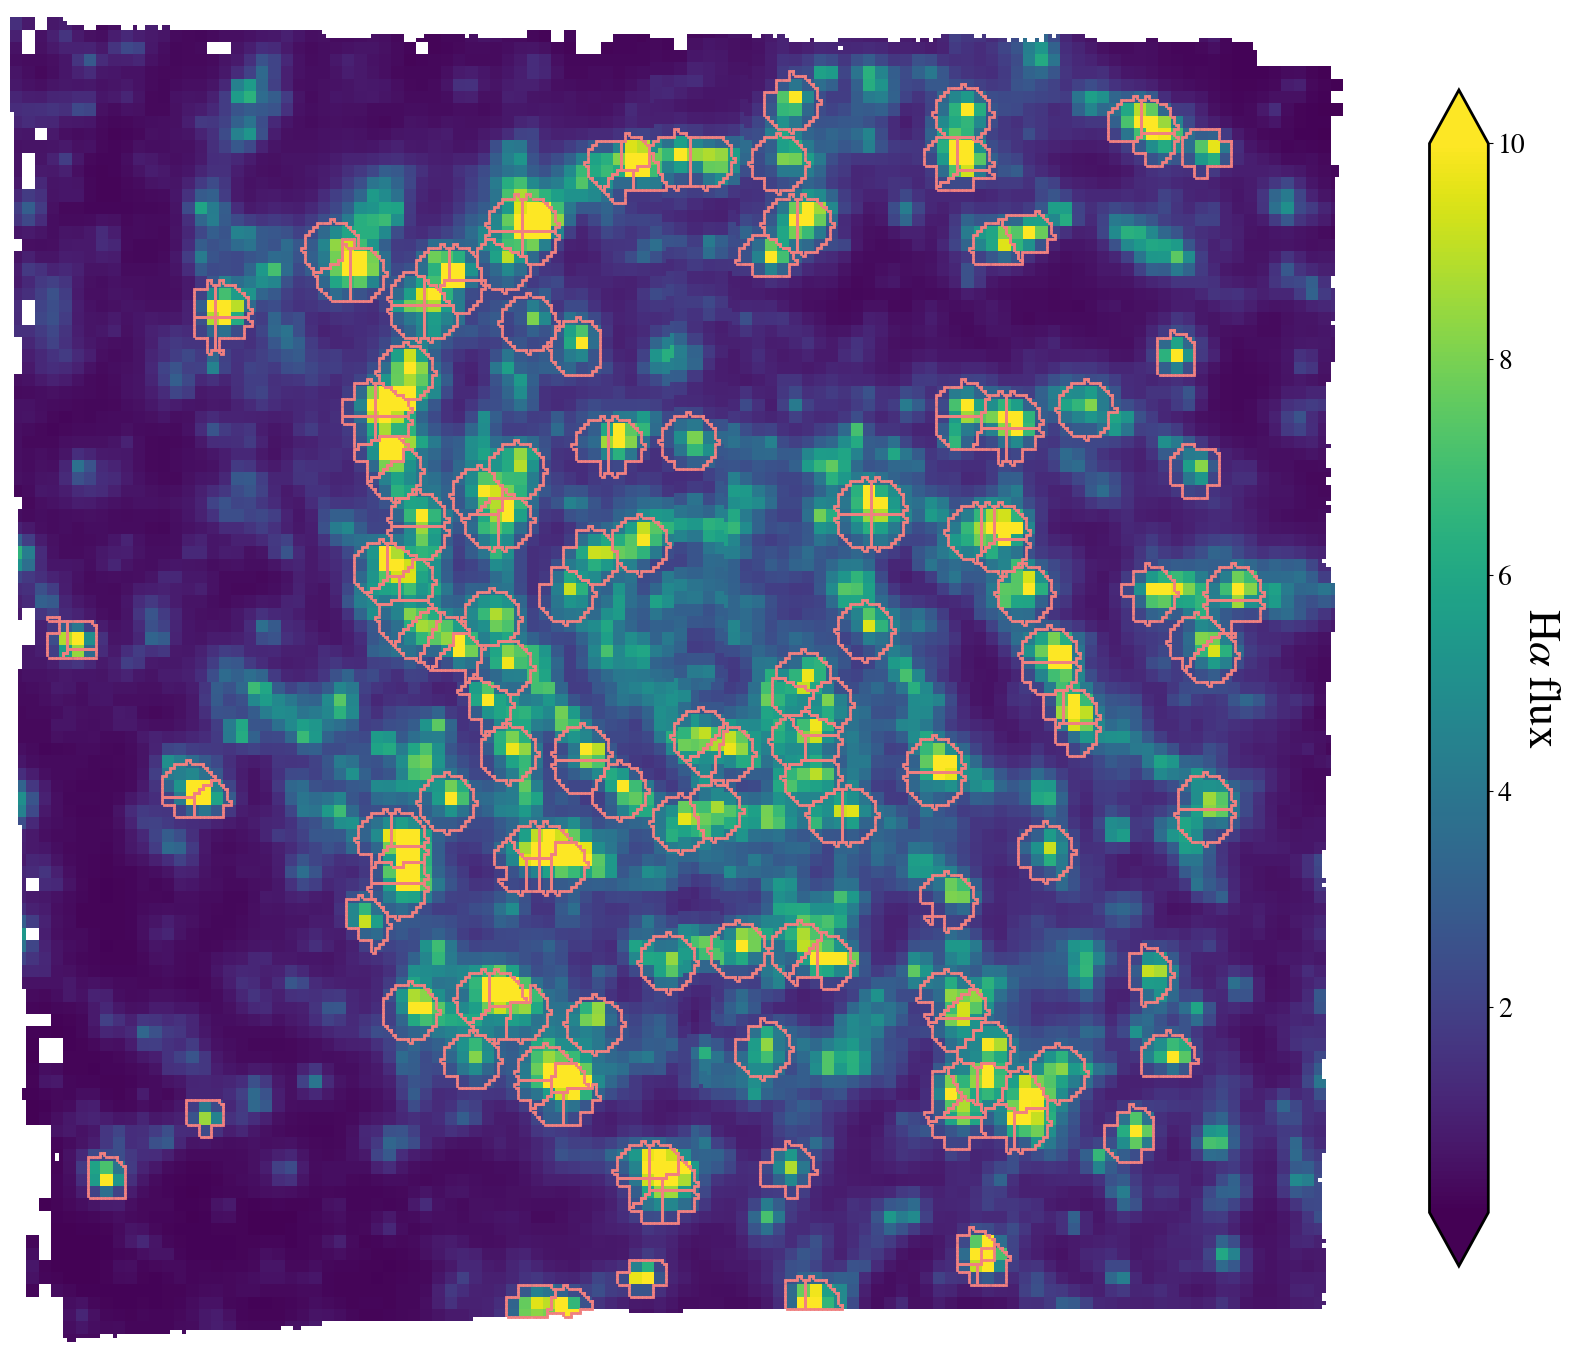

In [45]:
# flux min = 8
halpha_map_mask = ma.masked_where(HaEW_sn<14, halpha_map)
HIIdentify_plots.map_region_outline(galaxy_map=halpha_map_mask, \
            seg_map_fname='NGC4030_HII_segmentation_map.fits', vmin=0.1, vmax=10,\
            log_scaling=False, origin='lower', cbar_label=r'H$\alpha$ flux', \
            linewidth=2, tdir='./', galaxy_name='NGC4030', \
            parameter_name='ha')


Saved  ./NGC4030ha_regionoutlines.png 



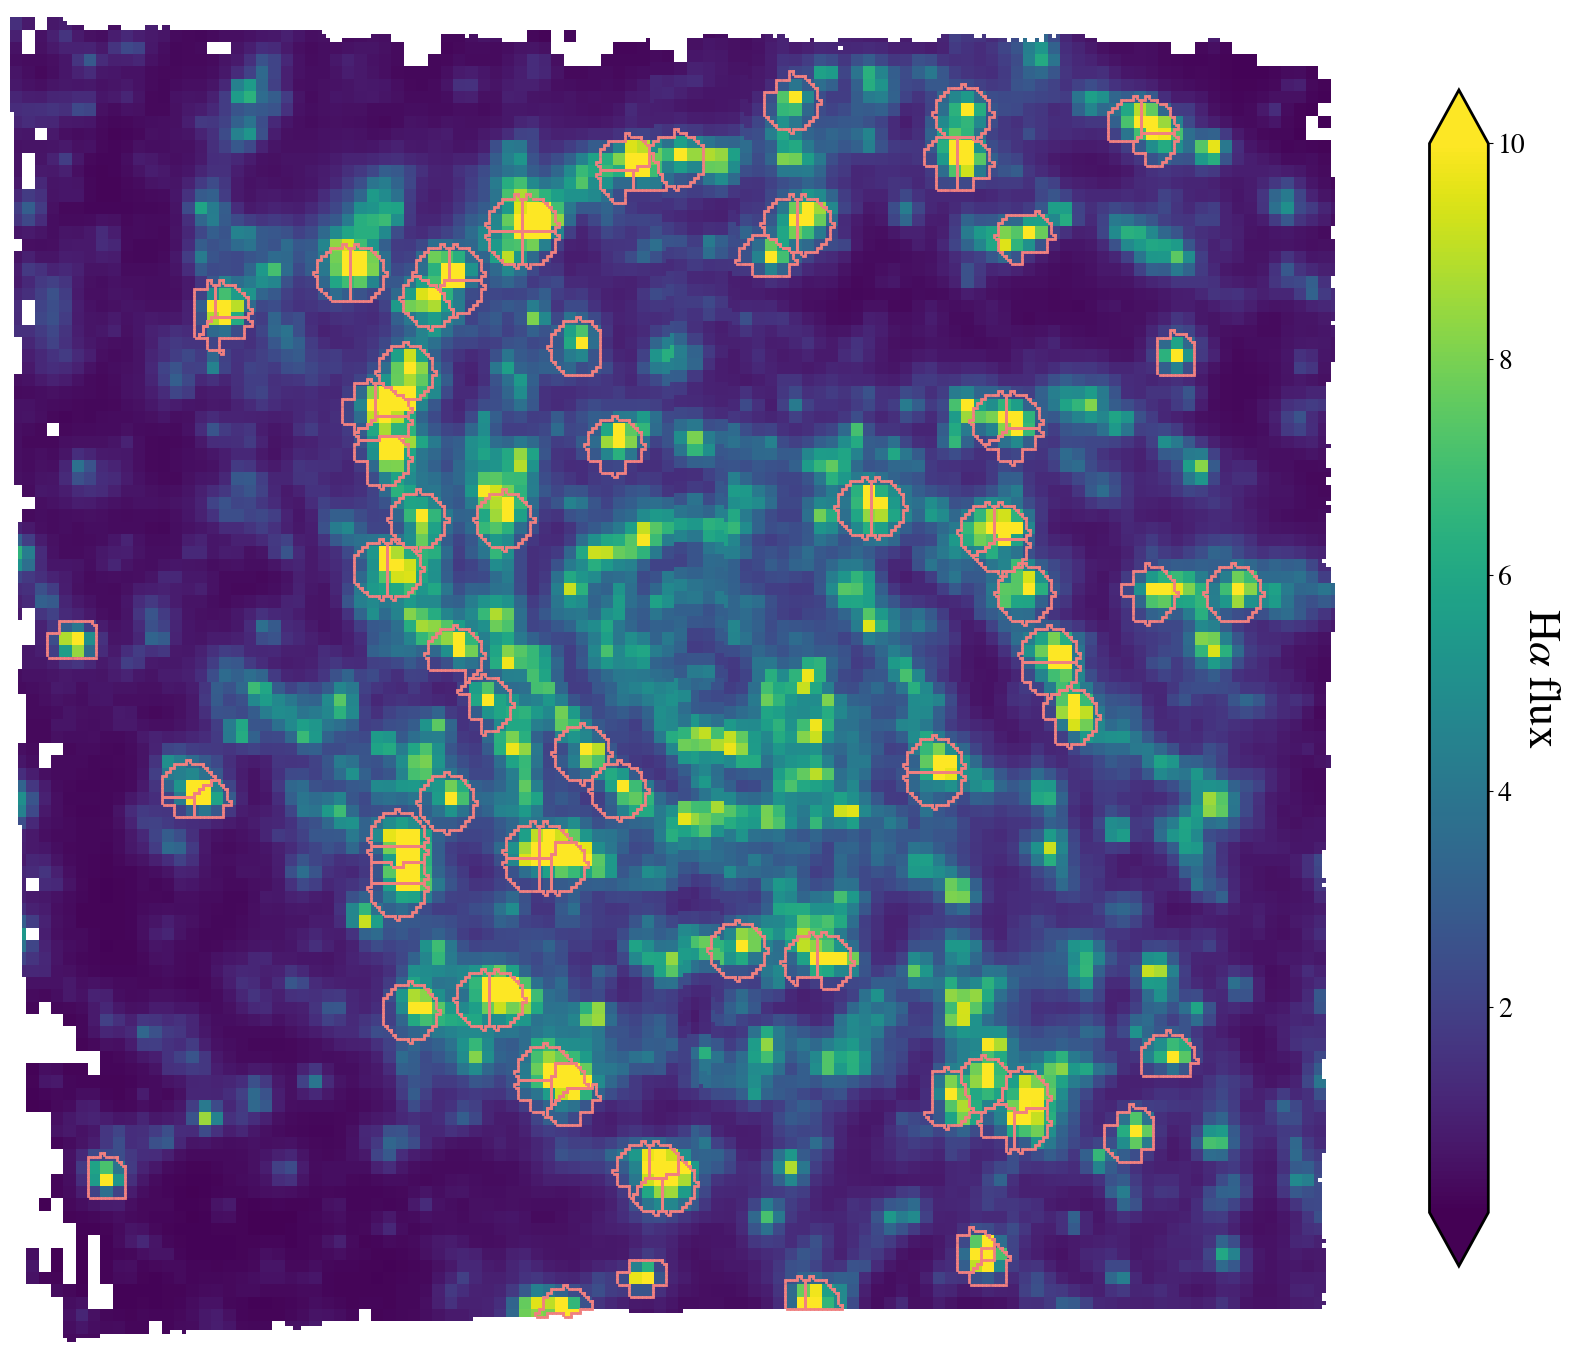

In [42]:
# flux min = 10
halpha_map_mask = ma.masked_where(HaEW_sn<20, halpha_map)
HIIdentify_plots.map_region_outline(galaxy_map=halpha_map_mask, \
            seg_map_fname='NGC4030_HII_segmentation_map.fits', vmin=0.1, vmax=10,\
            log_scaling=False, origin='lower', cbar_label=r'H$\alpha$ flux', \
            linewidth=2, tdir='./', galaxy_name='NGC4030', \
            parameter_name='ha')

In [5]:
tracker_map = fits.open('NGC4030_HII_trackermaps.fits')
tracker_map.info()

Filename: NGC4030_HII_trackermaps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PEAKS TRACKER    1 ImageHDU         8   (326, 326)   float64   
  2  PIXELS TRACKER    1 ImageHDU         8   (326, 326)   float64   


In [11]:
pix_tracker

array([[-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       ...,
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.]])

50th percentile: -16.26
16th percentile: -55.38
84th percentile: 24.88


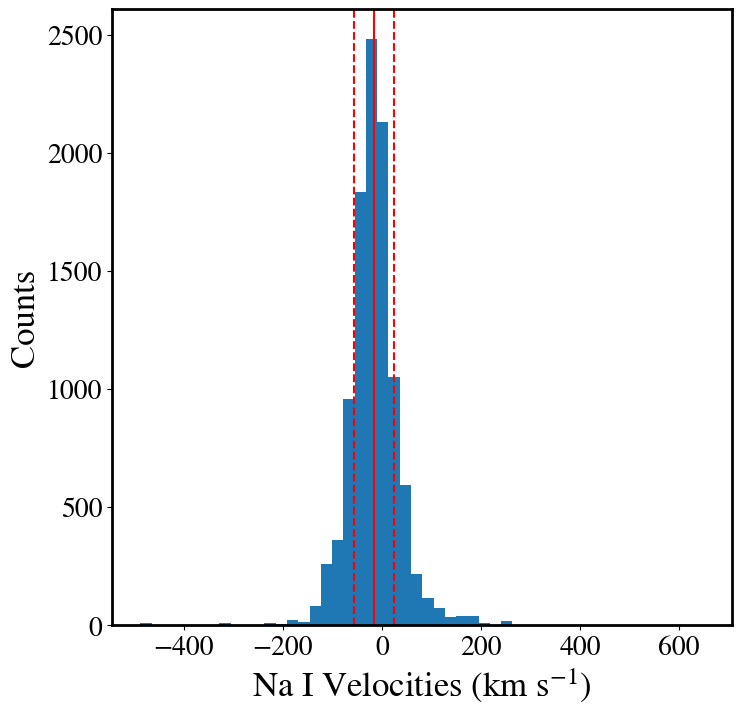

In [35]:
gas_vel_pix_tracker = gas_vel_mask[pix_tracker==2]
gas_vel_real_pix_tracker = gas_vel_pix_tracker.compressed()


plt.hist(gas_vel_real_pix_tracker,bins=50)
plt.ylabel('Counts')
plt.xlabel(r'Na I Velocities (km s$^{-1}$)')
plt.axvline(np.percentile(gas_vel_real_pix_tracker,50),c='red')
plt.axvline(np.percentile(gas_vel_real_pix_tracker,16),c='red',ls='--')
plt.axvline(np.percentile(gas_vel_real_pix_tracker,84),c='red',ls='--')


plt.annotate()
print('50th percentile: {:.2f}'.format(np.percentile(gas_vel_real_pix_tracker,50) ) );
print('16th percentile: {:.2f}'.format(np.percentile(gas_vel_real_pix_tracker,16) ) );
print('84th percentile: {:.2f}'.format(np.percentile(gas_vel_real_pix_tracker,84) ) );

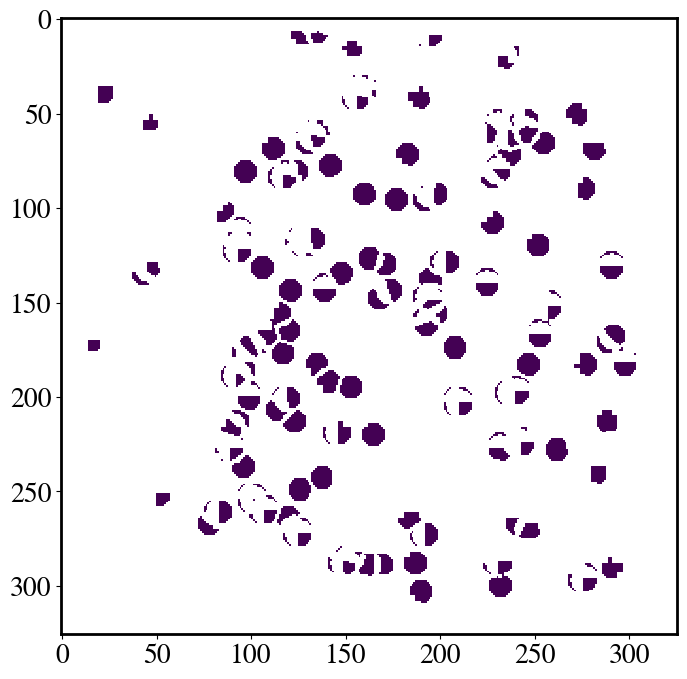

In [12]:
pix_tracker = tracker_map['PIXELS TRACKER'].data
peak_tracker = tracker_map['PEAKS TRACKER'].data

pix_tracker_mask = ma.masked_where(pix_tracker!=2, pix_tracker)

plt.imshow(pix_tracker_mask)

In [4]:
# load the data
file = fits.open('NGC4030_0.6_err_corr_mcmc_output.fits')
table_all = Table(file[1].data)
gas_vel_map = file[2].data

# filter out bad values
table_good = table_all[table_all['velocities'] > -999]
# exclude velocities with high confidence interval widths
vel_widths = np.absolute(table_good['vel_uncert_84th_percent']-table_good['vel_uncert_16th_percent'])

vel_width_map = np.zeros(gas_vel_map.shape)
for binid in table_good['bin']:
    index = np.where(binid_map == binid)
    binid_indx = np.where(table_good['bin']== binid)
    vel_width_map[index] = vel_widths[binid_indx][0]
        
vel_widths_filt = vel_widths[vel_widths<100]
table_uniq = table_good[vel_widths<100]

In [10]:
def get_ew_from_percentiles(binid,binid_map, stellar_vel,redshift, obswave, LSFvel):
    ind = binid_map == binid
    # single bin velocity

    binvel = stellar_vel[ind][0]
#     # single flux, error and model spectrum corresponding to that bin
#     flux_bin = np.ma.array(flux[:, ind][:, 0])
#     err_bin = np.ma.array(error[:, ind][:, 0])
#     mod_bin = np.ma.array(model[:, ind][:, 0])

    # Determine bin redshift:
    c = 2.998e5
    bin_z = redshift + ((1 + redshift) * binvel / c)
    restwave = obswave / (1.0 + bin_z)

    binid_indx = table_uniq['bin'] == binid
    model_fit_bin = model_NaI.model_NaI(table_uniq['percentiles'][binid_indx][0][:, 0], LSFvel, restwave)
    
    # Focus on D2 component(5891 angstrom)
    fitlim = [5887, 5894]
    D2_flux = model_fit_bin['modflx'][(restwave > fitlim[0]) & (restwave < fitlim[1])]
    
    delta_lam = restwave[1] - restwave[0]
    ew = np.sum( (1 - (D2_flux / 1) ) * delta_lam ) # flux is already normalized so continuum=1

    return ew

def get_ew_map(binid_map, redshift, stellar_vel, obswave,LSFvel):

    # create ew map
    ew_map = np.zeros(binid_map.shape)

    for binid in range(np.max(binid_map)):

        ew = get_ew_from_percentiles(int(binid),binid_map, redshift, stellar_vel, obswave, LSFvel)
        ind = binid_map == binid
        ew_map[ind] = ew

    return ew_map

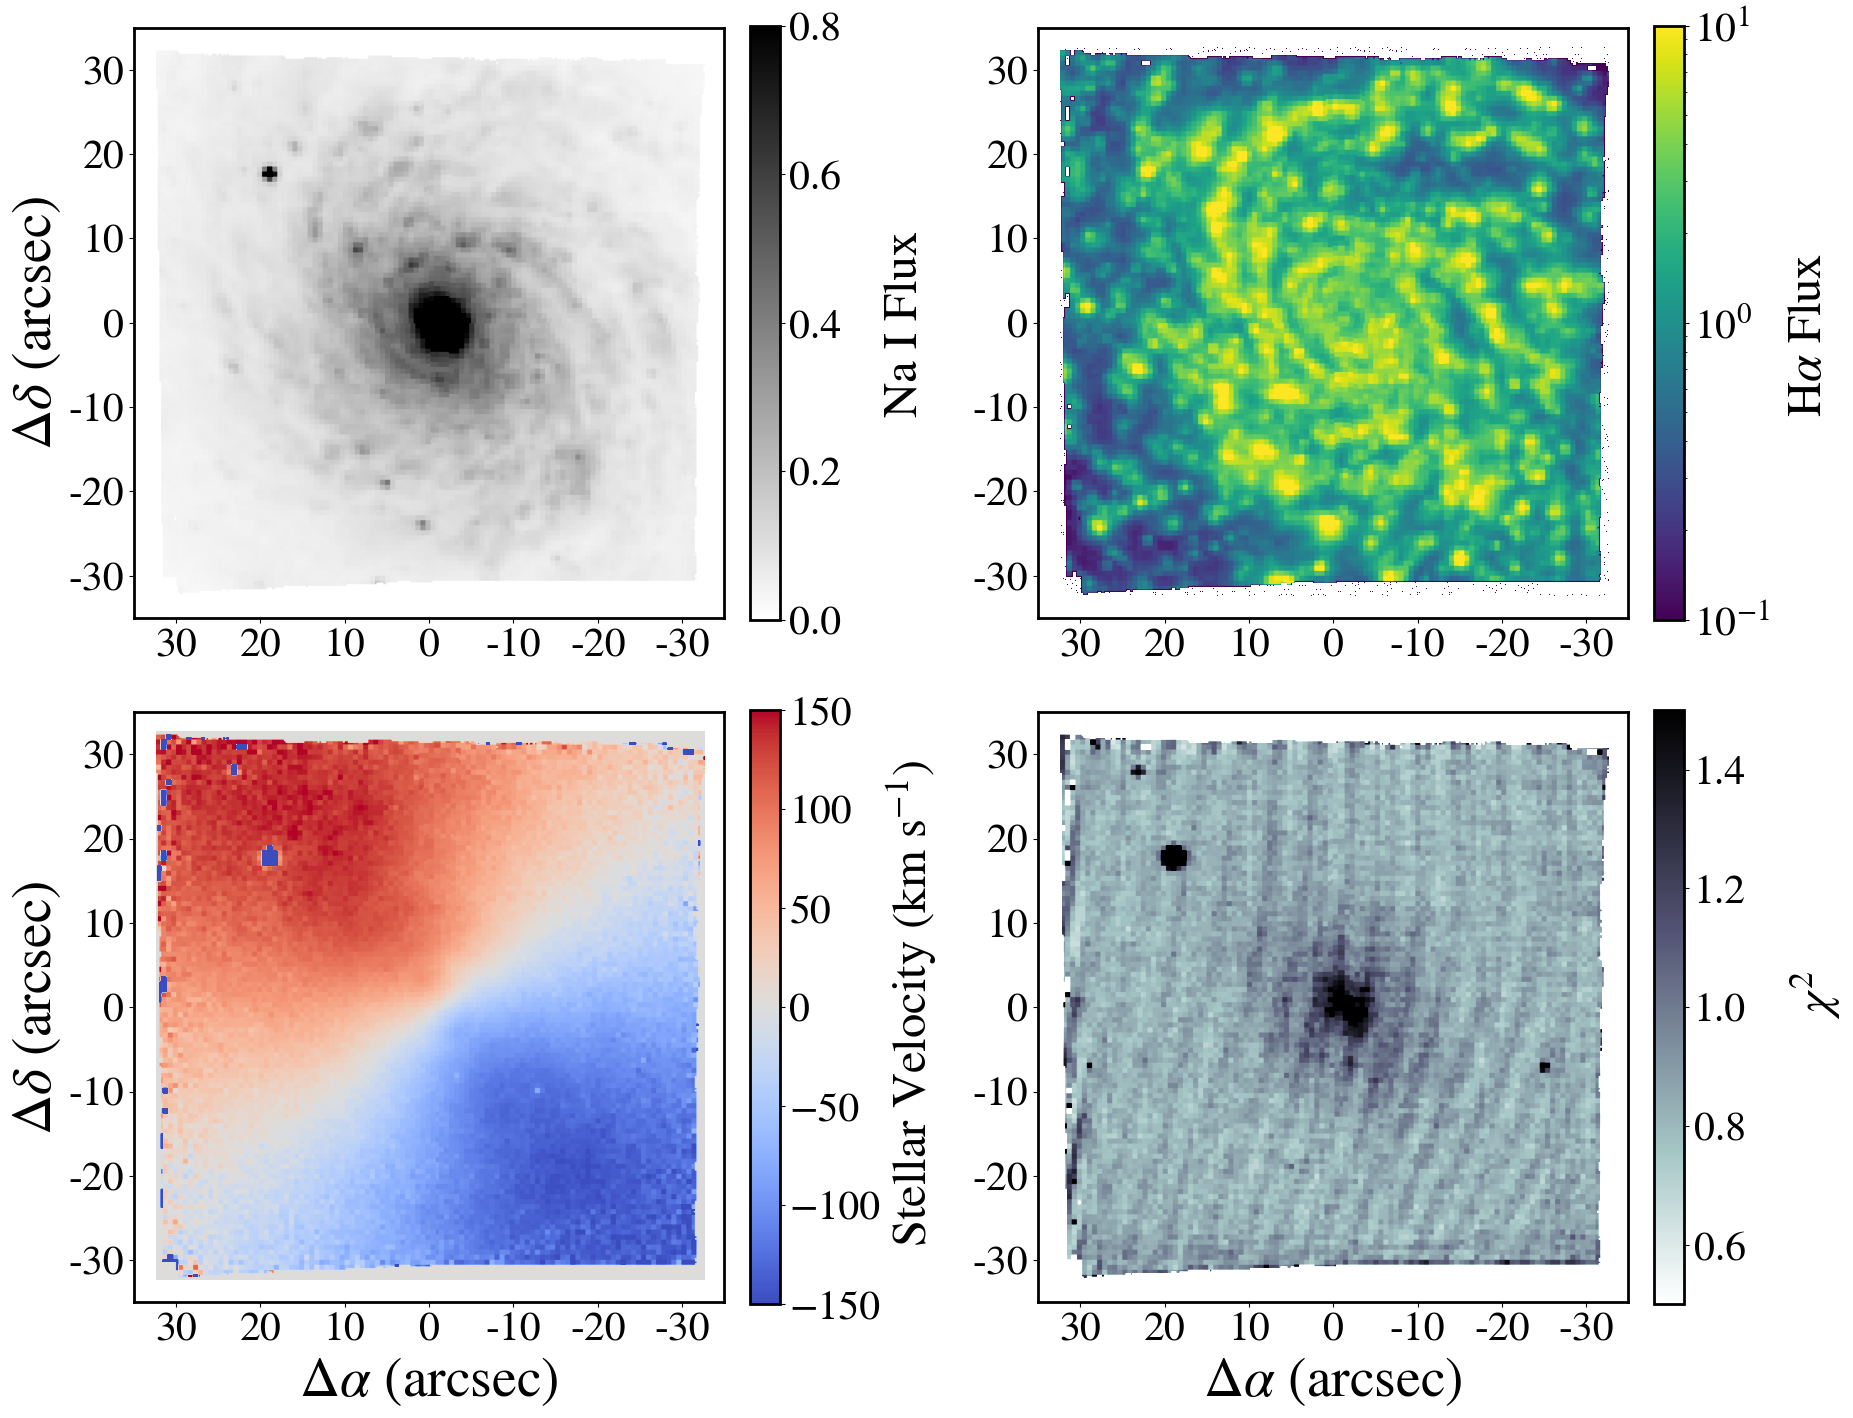

In [10]:
plt.rcParams['figure.figsize'] = (20,20) 
fig = plt.figure()
gs = fig.add_gridspec(2, 2, hspace=-0.2, wspace=.4)
(ax1, ax2), (ax3, ax4) = gs.subplots()

# fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,sharey=True,sharex=True,squeeze=True,hspace=0)
# fig.tight_layout(pad=0.1)

# set the tick range for each image
tick_range = np.arange(-30,40,10)

# Median Na I flux map
NaI_img = ax1.imshow(img_data,origin='lower',cmap='gray_r',vmin = 0,vmax=.8,
          extent=[32.4, -32.6,-32.4, 32.6])

ax1.set_xticks(tick_range,labels=tick_range,fontsize=30)
ax1.set_yticks(tick_range,labels=tick_range,fontsize=30)
ax1.set_xlim(35,-35)
ax1.set_ylim(-35,35)

ax1.set_ylabel(r'$\Delta \delta$ (arcsec)',fontsize=40)
#ax1.set_xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=24)

NaI_clb = fig.colorbar(NaI_img, ax=ax1,fraction=0.046, pad=0.04)
NaI_clb.ax.tick_params(labelsize=30)
# NaI_clb.set_label(r'Na I Flux (10$^{-20}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$)',fontsize=20,rotation = 90,
#                  labelpad = 4)
ax1.text(-54,-10,r'Na I Flux',rotation=90,fontsize=35)
# ax1.text(-50,-30.5,r'Na I Flux (10$^{-20}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$)',rotation=90,fontsize=28)

sfr = ax2.imshow(halpha_map,origin='lower',cmap='viridis', norm=colors.LogNorm(vmin=.1,vmax=10),
          extent=[32.4, -32.6,-32.4, 32.6])

ax2.set_xticks(tick_range,labels=tick_range,fontsize=30)
ax2.set_yticks(tick_range,labels=tick_range,fontsize=30)
ax2.set_xlim(35,-35)
ax2.set_ylim(-35,35)
sfr_clb = fig.colorbar(sfr, ax=ax2,fraction=0.046, pad=0.04) 
sfr_clb.ax.tick_params(labelsize=30)
# sfr_clb.set_label(r'H$\alpha$ Flux (10$^{-20}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$)',fontsize=20,rotation = 90)
# ax2.text(-50,-29,r'H$\alpha$ Flux (10$^{-20}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$)',rotation=90,fontsize=28)
ax2.text(-54,-10,r'H$\alpha$ Flux',rotation=90,fontsize=35)

stell_vel = ax3.imshow(stellar_vel,origin='lower',cmap='coolwarm',vmin=-150,vmax=150,
          extent=[32.4, -32.6,-32.4, 32.6])

ax3.set_xticks(tick_range,labels=tick_range,fontsize=30)
ax3.set_yticks(tick_range,labels=tick_range,fontsize=30)
ax3.set_xlim(35,-35)
ax3.set_ylim(-35,35)
ax3.set_ylabel(r'$\Delta \delta$ (arcsec)',fontsize=40)

ax3.set_xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=40)
stell_clb = fig.colorbar(stell_vel, ax =ax3, fraction=0.046, pad=0.04);
stell_clb.ax.tick_params(labelsize=30)
# stell_clb.set_label('Stellar Velocity (km/s)',fontsize=24,rotation = 90)
ax3.text(-54,-27,r'Stellar Velocity (km s$^{-1}$)',rotation=90,fontsize=35)

chi2_map = NGC4030_map['STELLAR_FOM'].data[2]
#norm=colors.LogNorm(vmin=.1,vmax=10)
#vmin=0,vmax=1.5
chi_sqr = ax4.imshow(chi2_map,origin='lower',cmap='bone_r',vmin=.5,vmax=1.5,
          extent=[32.4, -32.6,-32.4, 32.6])

ax4.set_xticks(tick_range,labels=tick_range,fontsize=30)
ax4.set_yticks(tick_range,labels=tick_range,fontsize=30)
ax4.set_xlim(35,-35)
ax4.set_ylim(-35,35)
#ax4.set_ylabel(r'$\Delta \delta$ (arcsec)',fontsize=24)
#ax4.ylabel(r'$\Delta \delta$ (arcsec)',fontsize=24)
ax4.set_xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=40)
chi2_clb = fig.colorbar(chi_sqr, ax = ax4, fraction=0.046, pad=0.04)
chi2_clb.ax.tick_params(labelsize=30)
# chi2_clb.set_label(r'$\chi^2$',fontsize=24,rotation = 90,labelpad=.1)
ax4.text(-54,0,r'$\chi^2$',rotation=90,fontsize=35);
fig.savefig('/Users/erickaguirre/Desktop/paper_plots/0.6_err_corr_plots/0.6_DAP_output.pdf',
           bbox_inches='tight');

In [5]:
HII_seg_file = fits.open('NGC4030_HII_segmentation_map.fits')
HII_seg_map = HII_seg_file['REGION FLUX MAP'].data
HII_seg_contour_map = HII_seg_file['REGION_IDS'].data

In [16]:
HII_seg_file.info()

Filename: NGC4030_HII_segmentation_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  REGION_IDS    1 ImageHDU         8   (326, 326)   float32   
  2  DISTANCE FROM PEAK    1 ImageHDU         8   (326, 326)   float32   
  3  PEAKS MAP     1 ImageHDU         8   (326, 326)   float32   
  4  REGION FLUX MAP    1 ImageHDU         8   (326, 326)   float32   


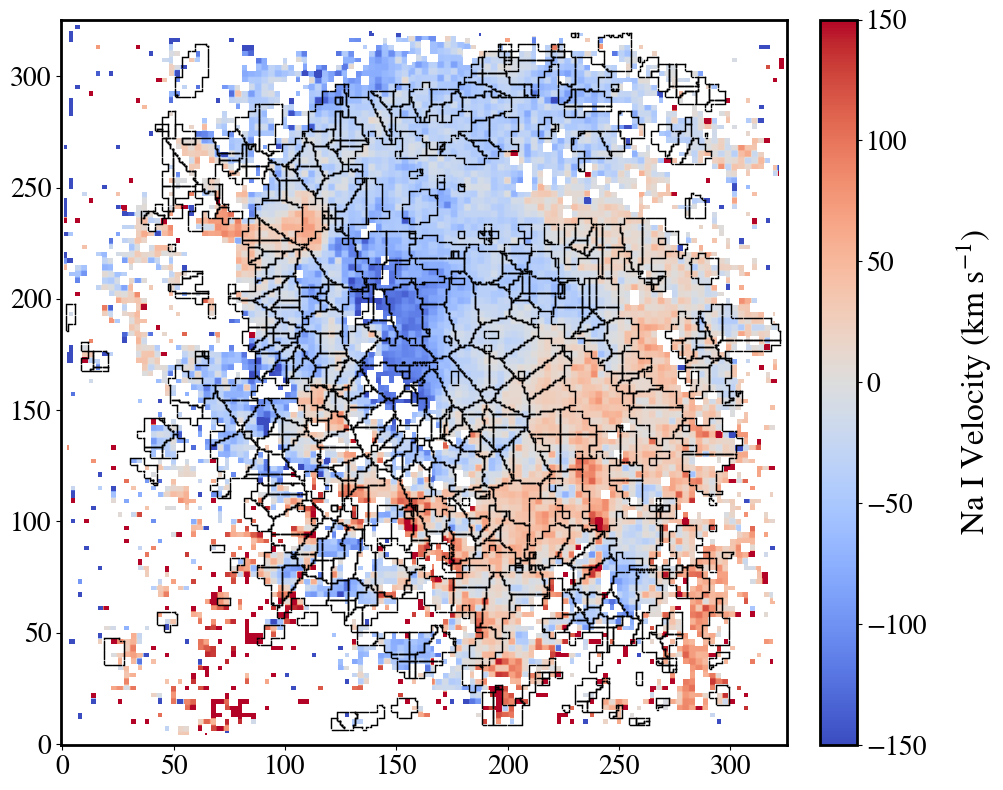

In [25]:
# def map_region_outline(galaxy_map, seg_map_fname, vmin=None, vmax=None, log_scaling=True,
#                        origin='lower', cbar_label='', linewidth=2, tdir='./', galaxy_name='',
#                        parameter_name=''):
#     """
#     Produces a plot of the galaxy map, with the outlines of the identified HII regions
#     overlaid.

#     galaxy_map: 2d array
#         Map to be plotted, e.g. map of Ha flux
#     seg_map_fname: str
#         Path to segmentation map produced by HIIdentify
#     vmin, vmax: floats
#         Set to define the min and max of the colour scaling. Default = None.
#     log_scaling: bool
#         If True, the colour of the map will use log scaling, otherwise linear scaling will
#         be used.
#     origin: str
#         Passed to plt.imshow. Default: 'lower' is used to account for fits.open flipping the
#         map.
#     cbar_label: str
#         If given, label for the colourbar
#     linewidth:float
#         Linewidth for the region outlines. Default = 2.
#     tdir: str
#         Target directory for saving the file. Default='./'.
#     galaxy_name: str
#         Used for naming the output file. Default = ''.
#     parameter_name: str
#         Used for naming the output file. Default = ''.

#     """
#     HIIdentify_plots.map_region_outline(galaxy_map=halpha_map_mask, \
#             seg_map_fname='NGC4030_HII_segmentation_map.fits', vmin=0.1, vmax=10,\
#             log_scaling=False, origin='lower', cbar_label=r'H$\alpha$ flux', \
#             linewidth=2, tdir='./', galaxy_name='NGC4030', \
#             parameter_name='ha')

# flux min = 4
galaxy_map = gas_vel_mask
seg_map_fname='NGC4030_HII_segmentation_map.fits'
vmin=-150
vmax=150
cbar_label=r'Na I Velocity (km s$^{-1}$)'
linewidth=1
tdir='./'
galaxy_name='NGC4030'
origin='lower'

fig,axes = plt.subplots(figsize=(10,8))

norm_kw = {'vmin':vmin, 'vmax':vmax}
plt.imshow(galaxy_map, origin=origin, **norm_kw,cmap='coolwarm')
# origin = 'lower' accounts for the fact that fits.open flips the map
cbar = plt.colorbar(fraction=0.046, pad=0.04)

cbar.set_label(cbar_label, rotation=90, size=24, labelpad=20)
#axes.axis('off') #remove x and y ticks & labels for the map
fig.tight_layout()



#Draw outlines around regions
with fits.open(seg_map_fname) as tmp:
    region_IDs = tmp['Region_IDs'].data
regions = np.unique(region_IDs[region_IDs > 0])
for r in regions:
    sel = region_IDs == r
    segments = HIIdentify_plots.draw_region_outlines(sel, x1 = sel.shape[1], y1= sel.shape[0])
    plt.plot(segments[:,0], segments[:,1], color='k', linewidth=linewidth)

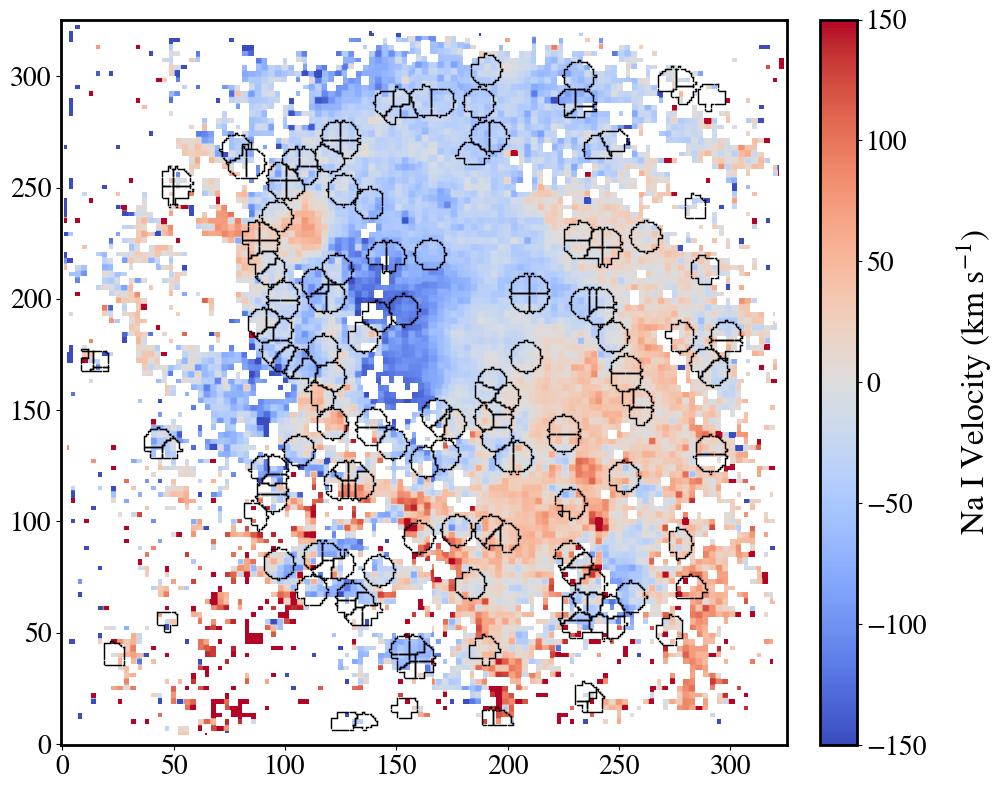

In [8]:
# flux min = 10
galaxy_map = gas_vel_mask
seg_map_fname='NGC4030_HII_segmentation_map.fits'
vmin=-150
vmax=150
cbar_label=r'Na I Velocity (km s$^{-1}$)'
linewidth=1
tdir='./'
galaxy_name='NGC4030'
origin='lower'

fig,axes = plt.subplots(figsize=(10,8))

norm_kw = {'vmin':vmin, 'vmax':vmax}
plt.imshow(galaxy_map, origin=origin, **norm_kw,cmap='coolwarm')
# origin = 'lower' accounts for the fact that fits.open flips the map
cbar = plt.colorbar(fraction=0.046, pad=0.04)

cbar.set_label(cbar_label, rotation=90, size=24, labelpad=20)
#axes.axis('off') #remove x and y ticks & labels for the map
fig.tight_layout()



#Draw outlines around regions
with fits.open(seg_map_fname) as tmp:
    region_IDs = tmp['Region_IDs'].data
regions = np.unique(region_IDs[region_IDs > 0])
for r in regions:
    sel = region_IDs == r
    segments = HIIdentify_plots.draw_region_outlines(sel, x1 = sel.shape[1], y1= sel.shape[0])
    plt.plot(segments[:,0], segments[:,1], color='k', linewidth=linewidth)

In [1]:
plt.rcParams['figure.figsize'] = (8,8)
gas_vel_mask = ma.masked_where((vel_width_map>100) | (binid_map==-1), gas_vel_map)
#gas_vel_mask = ma.masked_where((gas_vel_mask>-400) & (gas_vel_mask < 400),gas_vel_mask)
plt.imshow(gas_vel_mask,origin='lower',cmap='coolwarm',vmin=-150,vmax=150,
          extent=[32.4, -32.6,-32.4, 32.6])

plt.xlim(35,-35)
plt.ylim(-35,35)

plt.ylabel(r'$\Delta \delta$ (arcsec)',fontsize=28)
plt.xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=28)
clb = plt.colorbar(fraction=0.046, pad=0.04);
clb.set_label('Na I Velocity (km/s)',fontsize=28,rotation = 90)
plt.savefig('/Users/erickaguirre/Desktop/paper_plots/0.6_err_corr_plots/NaI_velocities.pdf',
            bbox_inches='tight');

NameError: name 'plt' is not defined

In [59]:
def NaImcmc(table_uniq,binid, redshift, binid_map, stellar_vel, 
            flux, model, error, obswave, LSFvel,vel_widths_filt):
    ind = binid_map == binid
    # single bin velocity
    binvel = stellar_vel[ind][0]
    # single flux, error and model spectrum corresponding to that bin
    flux_bin = np.ma.array(flux[:, ind][:, 0])
    err_bin = np.ma.array(error[:, ind][:, 0])
    mod_bin = np.ma.array(model[:, ind][:, 0])
    
    # speed of light in km/s
    c = 2.998e5
    # Na I doublet vacuum absorption wavelengths 
    D2 = 5891.582 # in angstroms
    D1 = 5897.558 # in angstroms
    blim = [5850.0,5870.0]
    rlim = [5910.0,5930.0]
    # wavelength fitting range inside of NaI region
    fitlim = [5875.0,5915.0]

    # Determine bin redshift:
    bin_z = redshift + ((1 + redshift) * binvel / c)
    restwave = obswave / (1.0 + bin_z)
    # convert wavelength array from angstroms to velocity space
    vel_space = ( (restwave/D1) - 1 ) * c
    
    # observed flux (gas+continuum model)
    tot_ndata = continuum_normalize_NaI.norm(restwave, mod_bin, err_bin, blim, rlim, FIT_FLG=1,smod=flux_bin)
    # continuum model
    mod_ndata = continuum_normalize_NaI.norm(restwave, mod_bin, err_bin, blim, rlim, FIT_FLG=0)
    # gas flux (total flux / continuum)
    gas_ndata = continuum_normalize_NaI.smod_norm(restwave, flux_bin, err_bin, mod_bin, blim, rlim)

    # Cut out NaI
    select_obs = np.where((tot_ndata['nwave'] > fitlim[0]) & (tot_ndata['nwave'] < fitlim[1]))
    select_mod = np.where((mod_ndata['nwave'] > fitlim[0]) & (mod_ndata['nwave'] < fitlim[1]))
    select_gas = np.where((gas_ndata['nwave'] > fitlim[0]) & (gas_ndata['nwave'] < fitlim[1]))

    restwave_NaI = tot_ndata['nwave'][select_obs].astype('float64')
    rest_vel = vel_space[select_obs].astype('float64')
    obsflux_NaI = tot_ndata['nflux'][select_obs].astype('float64')
    err_NaI = tot_ndata['nerr'][select_obs].astype('float64')
    sres_NaI = LSFvel
    mod_NaI = mod_ndata['nflux'][select_mod].astype('float64')
    gas_NaI = gas_ndata['nflux'][select_gas].astype('float64')
    
    data = {'wave': restwave_NaI, 'rest_vel': rest_vel,'tot_flux': obsflux_NaI,
            'model': mod_NaI, 'gas_flux': gas_NaI,'err': err_NaI, 'velres': sres_NaI,'S_N':tot_ndata['s2n']}

    binid_indx = table_uniq['bin'] == binid
    model_fit_bin = model_NaI.model_NaI(table_uniq['percentiles'][binid_indx][0][:, 0], 
                                        data['velres'], data['wave'])
    lamb_centroid = table_uniq['percentiles'][binid_indx][0][0,0]
    vel_centroid = ( (lamb_centroid/D1) - 1) * c
    vel_vals =np.array([vel_centroid,table_uniq['vel_uncert_84th_percent'][binid_indx][0],
                        table_uniq['vel_uncert_16th_percent'][binid_indx][0]])
    bin_vel_width = vel_widths_filt[binid_indx]
    
#     lamb_stats = table_uniq['percentiles'][binid_indx][0][0,:]
#     lamb_84 = lamb_stats[1] + lamb_stats[0]
#     lamb_16 = lamb_stats[0] - lamb_stats[2]
#     lamb_vals = np.array([lamb_stats[0],lamb_84,lamb_16])
#     vel_vals = ( (lamb_vals/D2) - 1) * c
#     vel_upper_uncert = np.absolute(vel_vals[1] - vel_vals[0])
#     vel_lower_uncert = np.absolute(vel_vals[0]-vel_vals[2])
#     vel_stats = np.array([vel_vals[0],vel_upper_uncert,vel_lower_uncert])
    return data,model_fit_bin,vel_vals,bin_vel_width[0]

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/erickaguirre/packages/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


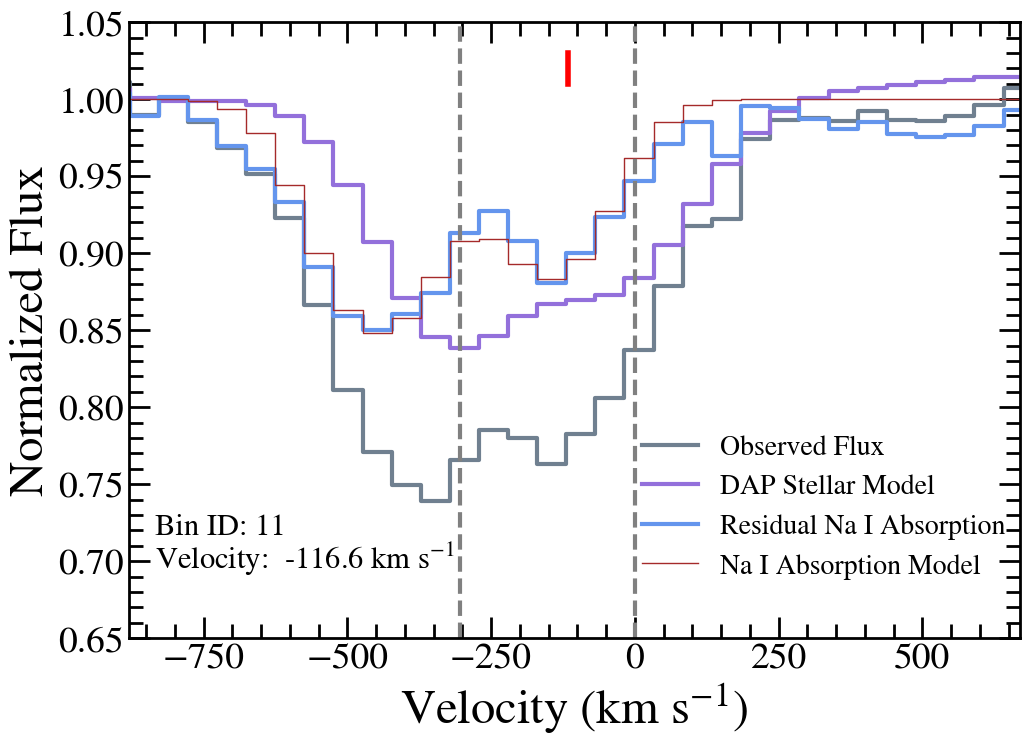

In [72]:
# get data around Na I region and the best-fit model to it
binid = 11
data_NaI, model_fit_bin_NaI,vel_vals,bin_vel_width = NaImcmc(table_uniq,binid, redshift, binid_map, 
                                                   stellar_vel, flux, model,error, wave,LSFvel,vel_widths_filt)

plt.rcParams['figure.figsize'] = (11.5,8)
plt.rc('xtick',labelsize=27)
plt.rc('ytick',labelsize=27)
fig, ax = plt.subplots()

ax.step(data_NaI['rest_vel'],data_NaI['tot_flux'],lw=3,label='Observed Flux',c='slategrey')
ax.step(data_NaI['rest_vel'],data_NaI['model'],lw=3,label='DAP Stellar Model',c='mediumpurple')
ax.step(data_NaI['rest_vel'],data_NaI['gas_flux'],lw=3,label='Residual Na I Absorption',c='cornflowerblue')
ax.step(data_NaI['rest_vel'],model_fit_bin_NaI['modflx'],lw=1,label='Na I Absorption Model',c='brown')

ax.axvline(0,c='grey',ls='--',lw=3)
ax.axvline( ( (D2/D1) - 1) * c ,c='grey',ls='--',lw=3)
ax.axvline(vel_vals[0], 0.9, 0.95, c='red',linewidth=4)
#ax.axhline( 1,c='grey',ls='--',lw=1)



ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major',direction='in',bottom=True, top=True, left=True, right=True,
                    length=15,width=2)
ax.tick_params(which = 'minor',direction='in',bottom=True, top=True, left=True, right=True,
                    length=10,width=2)

bin_txt = 'Bin ID: ' + str(binid)
vel50_txt = 'Velocity:  {:.1f}'.format(vel_vals[0]) + r' km s$^{-1}$'
# vel84_txt = '84th%: {:.1f}'.format(vel_vals[1])
# vel16_txt = '16th%: {:.1f}'.format(vel_vals[2])
# vel_width_txt = 'Delta V: {:.1f}'.format(bin_vel_width)

ax.annotate(bin_txt,(-835,0.717),fontsize=22)
ax.annotate(vel50_txt,(-835,0.695),fontsize=22)
# ax.annotate(vel84_txt,(-820,0.695),fontsize=16)
# ax.annotate(vel16_txt,(-820,0.68),fontsize=16)
# ax.annotate(vel_width_txt,(-820,0.665),fontsize=16)

ax.set_ylabel('Normalized Flux',fontsize=35)
ax.set_xlabel(r'Velocity (km s$^{-1}$)',fontsize=35)
ax.set_xlim(-880,670)
ax.set_ylim(0.65,1.05)
ax.legend(frameon=False,loc='best',bbox_to_anchor=(0.548, .37),fontsize=20);
plt.savefig('/Users/erickaguirre/Desktop/paper_plots/0.6_err_corr_plots/NaI_spectrum.pdf',bbox_inches='tight');